In [1]:
import numpy as np
import astropy.units as u

# Some plotting functions

In [2]:
import pylab as plt

In [3]:
from snewpy.rate_calculator import SmearingMatrix, DetectionChannel

In [4]:
def plot_matrix(m: SmearingMatrix):
    plt.pcolormesh(m.bins_true.value, m.bins_smeared.value, m.matrix.T)
    plt.xlabel('$E_{true}$, '+m.bins_true.unit._repr_latex_())
    plt.ylabel('$E_{smeared}$, '+m.bins_smeared.unit._repr_latex_())

In [5]:
def plot_quantity(x:u.Quantity, y:u.Quantity, xlabel=None, ylabel=None, **kwargs):
    """Plot the X vs Y array, with given axis labels, adding units"""

    #just in case we are passed bare np.arrays iwthout units
    x = u.Quantity(x)
    y = u.Quantity(y)
    
    if(len(x)==len(y)):
        plt.plot(x.value,y.value,**kwargs)
    else:
        plt.stairs(edges=x.value,values=y.value,**kwargs)
    if xlabel is not None:
        if(not x.unit.is_unity()):
            xlabel+=', '+x.unit._repr_latex_()
        plt.xlabel(xlabel)
    if ylabel is not None:
        if(not y.unit.is_unity()):
            ylabel+=', '+y.unit._repr_latex_()
        plt.ylabel(ylabel)

In [6]:
def plot_rate(rate, axis:str='time', **kwargs):
    if axis=='time':
        x = rate.time.to('s')
        y = rate.integrate_or_sum('energy').array.squeeze()
    elif axis=='energy':
        x = rate.energy.to('MeV')
        y = rate.integrate_or_sum('time').array.squeeze()
    else: 
        raise ValueError(f'axis="{axis}" should be one of "time","energy"')
    plot_quantity(x,y,xlabel=axis.capitalize(), ylabel='Event rate', **kwargs)


In [7]:
#a helper function to calculate total rate
from snewpy.flux import Container
def sum_rates(rates:list):
    res = sum([rate.array for rate in rates])
    rate = rates[0]#take first as an instance
    return Container(res,rate.flavor, rate.time, rate.energy, integrable_axes=rate._integrable_axes)

# Prepare the neturino flux

In [8]:
# prepare the neutrino flux from the model
from snewpy.models import ccsn
model = ccsn.Bollig_2016(progenitor_mass=27<<u.Msun)
times    = np.linspace(0,2,1500)<<u.second;
energies = np.linspace(0,50,501)<<u.MeV
flux = model.get_flux(t = times, E = energies, distance=10<<u.kpc)

# Reading the detector config from SNOwGLoBES

In [9]:
from snewpy.rate_calculator import RateCalculator

#load the RateCalculator object
rc = RateCalculator()

## List available detectors

In [10]:
#list available detectors
list(rc.detectors)

['wc100kt30prct',
 'wc100kt15prct',
 'ar40kt',
 'scint20kt',
 'halo1',
 'halo2',
 'novaND',
 'novaFD',
 'wc100kt30prct_he',
 'ar40kt_he',
 'icecube',
 'km3net',
 'ds20',
 'argo',
 'lz',
 'xent',
 'pandax']

## Read the detector you need

In [11]:
#read the detector
det = rc.read_detector('scint20kt')
det

/home/ash/work/snews2/snewpy/python/snewpy/rate_calculator.py:389: UserWarning: Efficiency not found for detector=scint20kt, channel=ibd. Using 100% efficiency
  warn(f'Efficiency not found for detector={name}, channel={ch.name}. Using 100% efficiency')
/home/ash/work/snews2/snewpy/python/snewpy/rate_calculator.py:389: UserWarning: Efficiency not found for detector=scint20kt, channel=nue_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={name}, channel={ch.name}. Using 100% efficiency')
/home/ash/work/snews2/snewpy/python/snewpy/rate_calculator.py:389: UserWarning: Efficiency not found for detector=scint20kt, channel=nuebar_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={name}, channel={ch.name}. Using 100% efficiency')
/home/ash/work/snews2/snewpy/python/snewpy/rate_calculator.py:389: UserWarning: Efficiency not found for detector=scint20kt, channel=numu_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={name}, channel={ch.name}

Detector(name="scint20kt", mass=20.0 kt, channels=['ibd', 'nue_e', 'nuebar_e', 'numu_e', 'numubar_e', 'nutau_e', 'nutaubar_e', 'nue_C12', 'nuebar_C12', 'nc_nue_C12', 'nc_nuebar_C12', 'nc_numu_C12', 'nc_numubar_C12', 'nc_nutau_C12', 'nc_nutaubar_C12', 'nue_C13', 'nc_nue_C13', 'nc_numu_C13', 'nc_nutau_C13', 'nc_nuebar_C13', 'nc_numubar_C13', 'nc_nutaubar_C13'])

## Inspecting the detector

In [12]:
#list all the channels
det.channels

{'ibd': DetectionChannel (flavor=NU_E_BAR, smearing=True, weight=0.1429),
 'nue_e': DetectionChannel (flavor=NU_E, smearing=True, weight=0.5716),
 'nuebar_e': DetectionChannel (flavor=NU_E_BAR, smearing=True, weight=0.5716),
 'numu_e': DetectionChannel (flavor=NU_X, smearing=True, weight=0.5716),
 'numubar_e': DetectionChannel (flavor=NU_X_BAR, smearing=True, weight=0.5716),
 'nutau_e': DetectionChannel (flavor=NU_X, smearing=True, weight=0.5716),
 'nutaubar_e': DetectionChannel (flavor=NU_X_BAR, smearing=True, weight=0.5716),
 'nue_C12': DetectionChannel (flavor=NU_E, smearing=True, weight=0.07066404999999999),
 'nuebar_C12': DetectionChannel (flavor=NU_E_BAR, smearing=True, weight=0.07066404999999999),
 'nc_nue_C12': DetectionChannel (flavor=NU_E, smearing=True, weight=0.07066404999999999),
 'nc_nuebar_C12': DetectionChannel (flavor=NU_E_BAR, smearing=True, weight=0.07066404999999999),
 'nc_numu_C12': DetectionChannel (flavor=NU_X, smearing=True, weight=0.07066404999999999),
 'nc_num

/home/ash/work/snews2/snewpy/python/snewpy/rate_calculator.py:354: RuntimeWarning: divide by zero encountered in log
  return np.interp(np.log(E)/np.log(10), xp, yp, left=0, right=0)*E*1e-38 <<u.cm**2


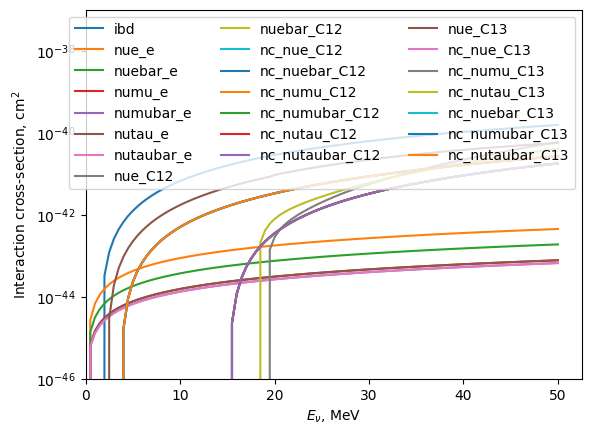

In [13]:
#plot all the channels cross-sections
E = np.linspace(0,50,101)<<u.MeV
for name,chan in det.channels.items():
    xs = chan.xsec(E)
    plot_quantity(E, xs, r'$E_\nu$', r'Interaction cross-section', label=name)
plt.legend(ncols=3)
plt.yscale('log')
plt.xlim(0)
plt.ylim(1e-46, 1e-37)
plt.show()

## Running the rate calculation

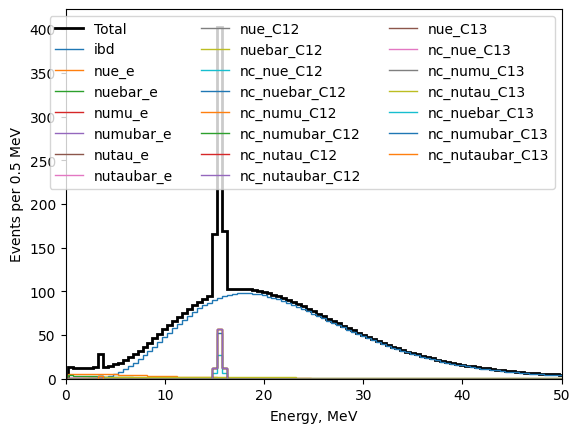

In [14]:
rates = det.run(flux)
plot_rate(sum_rates(list(rates.values())), axis='energy', label='Total', lw=2, color='k')
for chan,rate in rates.items():
    plot_rate(rate, axis='energy', label=chan)
#plt.yscale('log')
#plt.ylim(1e-2)
plt.legend(ncols=3)
plt.ylabel(f'Events per {rate.energy.diff()[0]<<u.MeV}')
plt.xlim(0,50)
plt.show()

# Defining a new detector

In [15]:
from snewpy.neutrino import Flavor
from snewpy.rate_calculator import Detector, DetectionChannel
#we can load cross-section from SNOwGLoBES to reuse
xsec_ibd=rc.load_xsec('ibd',Flavor.NU_E_BAR)
xsec_nc_c12=rc.load_xsec('nc_nue_C12',Flavor.NU_E)
# we can define smearing matrices 
e_true  = np.arange(0,50,0.1)<<u.MeV
e_smear = np.arange(0,50,0.1)<<u.MeV

#define the visible energy for IBD as function of 
def E_vis_ibd(E_nu:u.Quantity):
    return E_nu - 784*u.keV

#SmearingMatrix.from_Gaussian is a constructor based on a simple Gaussian distribution.

#we define matrices with with different resolution
m_smear_ibd=SmearingMatrix.from_Gaussian(e_true,e_smear,
                                         mean=E_vis_ibd,
                                         sigma=lambda e: 0.05*e #5% smearing
                                        )
m_smear_nc =SmearingMatrix.from_Gaussian(e_true,e_smear,
                                         mean=lambda e:15.1*u.MeV,
                                         sigma=0.5*u.MeV
                                        )
#create the detector with the same IBD channels but with three different smearings
det = Detector('scint_det', mass=20<<u.kt,
               channels={
                   'ibd':DetectionChannel(flavor=Flavor.NU_E_BAR,
                                          xsec=xsec_ibd, 
                                          efficiency=1., 
                                          smearing = m_smear_ibd, 
                                          weight=0.1429 #mass fraction of free protons in scint
                                         ),
                   'nc_C12':DetectionChannel(flavor=list(Flavor),#you can provide list of flavors
                                                 xsec=xsec_nc_c12, 
                                                 efficiency=1., 
                                                 smearing = m_smear_nc,
                                                 weight = 0.07 #mass fraction of C12
                                                ),
               })
det

Detector(name="scint_det", mass=20.0 kt, channels=['ibd', 'nc_C12'])

In [16]:
det.channels

{'ibd': DetectionChannel (flavor=NU_E_BAR, smearing=True, weight=0.1429),
 'nc_C12': DetectionChannel (flavor=NU_E,NU_X,NU_E_BAR,NU_X_BAR, smearing=True, weight=0.07)}

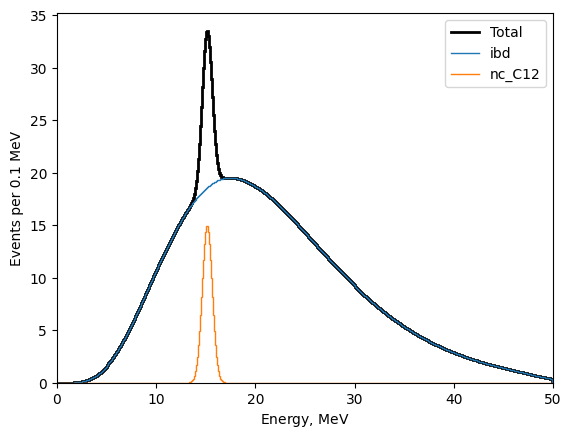

In [17]:
#plot the event rate in the detector
rates = det.run(flux)

plot_rate(sum_rates(list(rates.values())), axis='energy', label='Total', lw=2, color='k')
for chan,rate in rates.items():
    #integrate over time
    plot_rate(rate, axis='energy', label=chan)
#plot the total rate


plt.legend()
#plt.yscale('log')
#plt.ylim(1e-3)
plt.ylabel(f'Events per {rate.energy.diff()[0]}')
plt.xlim(0,50)
plt.show()

## Modifying the detector channels

In [18]:
#detector can be modified after creation 

#let's set the efficiency to the channels. 
#You can pass any function of energy, in this case we will make thresholds
det.channels['ibd'].efficiency = lambda e: 0.8*(e> 5*u.MeV)
det.channels['nc_C12'].efficiency = lambda e: 0.9*(e> 15*u.MeV)

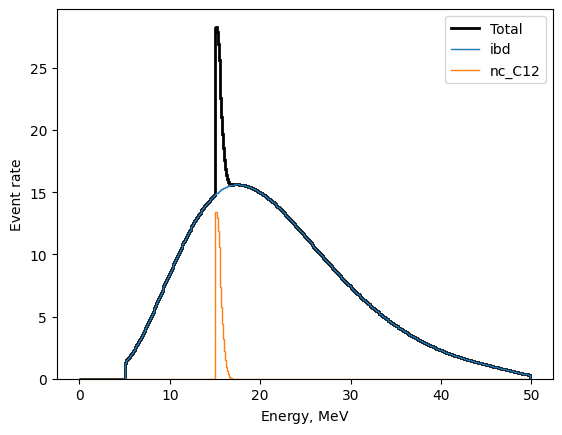

In [19]:
#plot the event rate in the detector
rates = det.run(flux)
plot_rate(sum_rates(list(rates.values())), axis='energy', label='Total', lw=2, color='k')
for chan,rate in rates.items():

    plot_rate(rate, axis='energy', label=chan)
plt.legend()
plt.show()

## Modifying the detector mass

In [20]:
det.mass = 100<<u.kt

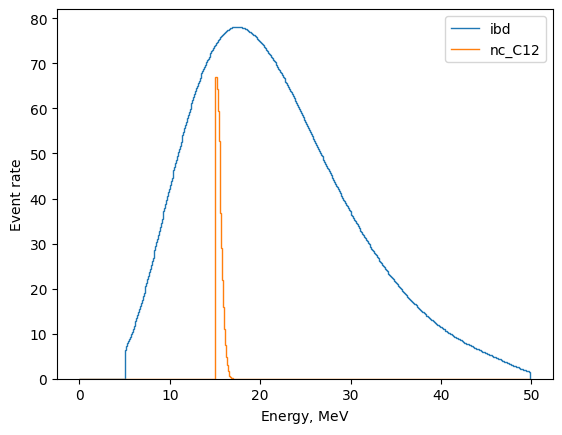

In [21]:
#plot the event rate in the detector
rates = det.run(flux)
for chan,rate in rates.items():
    #integrate over time
    plot_rate(rate, axis='energy', label=chan)
plt.legend()
#plt.yscale('log')
#plt.ylim(1e-3)
plt.show()